## Amazon Food Reviews - Agglomerative Clustering & DBSCAN

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import cross_validation
from sklearn.preprocessing import normalize
from scipy.sparse import find
from scipy.sparse import csr_matrix
from prettytable import PrettyTable

import collections

import warnings
warnings.filterwarnings("ignore")

In [3]:
df= pd.read_csv("../../../../Desktop/Prep/ML_Repo/amazon-fine-food-reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape

(568454, 10)

In [5]:
import pickle

def save_data(data,file):
    pickle.dump(data,open(file+".pkl","wb"))
    
def load_data(file):
    data = pickle.load(open(file+".pkl","rb"))
    return data

In [6]:
def sample_reviews(clust_size,clust_data,df_col_name):
    for i in range(clust_size + 1):
        print('Cluster Number ',clust_size + 1 )
        print('\n')
        print('Some of the reviews belonging to cluster ',i)
        print('\n')
        print(clust_data.loc[clust_data[df_col_name] == i]['Text'].tolist()[0])
        print('*' * 100)
        print(clust_data.loc[clust_data[df_col_name] == i]['Text'].tolist()[1])
        print('-' * 100)

In [7]:
cl_data = load_data('../Amazon_Food_Review_KNN/150k_nb')
cl_data['Score'].value_counts()

1    129548
0     20452
Name: Score, dtype: int64

In [8]:
cl_data_pos = cl_data[cl_data['Score'] == 1][:2500]
cl_data_neg = cl_data[cl_data['Score'] == 0][:2500]
cl_data = pd.concat([cl_data_pos,cl_data_neg])

In [9]:
cl_data = cl_data.drop('Score',axis=1)
cl_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Cleaned_Text
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...


### Bag of Words

In [10]:
from sklearn.preprocessing import Normalizer
count_vect = CountVectorizer()
x_bow = count_vect.fit_transform(cl_data['Cleaned_Text'].values)
normal_scale = Normalizer().fit(x_bow)
x_bow = normal_scale.transform(x_bow)
x_bow = x_bow.toarray()

### Agglomerative Clustering - BOW

In [11]:
from sklearn.cluster import AgglomerativeClustering

In [12]:
k_means_list = [i for i in range(2,8)]

In [13]:
for i in k_means_list:
    model = AgglomerativeClustering(n_clusters = i)
    model.fit(x_bow)
    cl_data['BOW_cluster_labels'] = model.labels_
    sample_reviews(max(model.labels_),cl_data, df_col_name = 'BOW_cluster_labels')

Cluster Number  2


Some of the reviews belonging to cluster  0


Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.
****************************************************************************************************
A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime.  Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull  moment.
----------------------------------------------------------------------------------------------------
Cluster Number  2


Some of the reviews belonging to cluster  1


For me, when the days get colder nothing is as rewarding as a simple cup of hot tea. And for it's claimed immunity benefits, a basic green tea is a common pick for maintaining a healthy natural balance during the flu season. From previous experiences in tasting the Tazo brand

Cluster Number  5


Some of the reviews belonging to cluster  0


Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.
****************************************************************************************************
A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime.  Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull  moment.
----------------------------------------------------------------------------------------------------
Cluster Number  5


Some of the reviews belonging to cluster  1


I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, conside

Cluster Number  7


Some of the reviews belonging to cluster  0


I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
****************************************************************************************************
This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
----------------------------------------------------------------------------------------------------
Cluster Number  7


Some of the reviews belonging to cluster  1


Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighte

### Agglomerative Clustering - Tf-Idf

In [14]:
tf_idf_vect = TfidfVectorizer()
x_bow = tf_idf_vect.fit_transform(cl_data['Cleaned_Text'].values)
normal_scale = Normalizer().fit(x_bow)
x_bow = normal_scale.transform(x_bow)
x_bow = x_bow.toarray()

In [15]:
for i in k_means_list:
    model = AgglomerativeClustering(n_clusters = i)
    model.fit(x_bow)
    cl_data['TFIDF_cluster_labels'] = model.labels_
    sample_reviews(max(model.labels_),cl_data, df_col_name = 'TFIDF_cluster_labels')

Cluster Number  2


Some of the reviews belonging to cluster  0


Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.
****************************************************************************************************
A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime.  Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull  moment.
----------------------------------------------------------------------------------------------------
Cluster Number  2


Some of the reviews belonging to cluster  1


For me, when the days get colder nothing is as rewarding as a simple cup of hot tea. And for it's claimed immunity benefits, a basic green tea is a common pick for maintaining a healthy natural balance during the flu season. From previous experiences in tasting the Tazo brand

Cluster Number  5


Some of the reviews belonging to cluster  0


Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.
****************************************************************************************************
A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime.  Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull  moment.
----------------------------------------------------------------------------------------------------
Cluster Number  5


Some of the reviews belonging to cluster  1


I have enjoyed Hershey's chocolate bars from the time that I was a child.  My two favorites are Hershey's Dark Chocolate and Hershey's Milk Chocolate with Almonds.  The combination of Hershey's sweet milk chocolate with chunks of whole almonds was a confectionary landmark tha

Cluster Number  6


Some of the reviews belonging to cluster  0


For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione Classic Espresso Pods.  It was the kindest, most wonderful Christmas present I can remember.  The espresso machine excels in quality and ease of use.  The espresso is exquisite.  Each time I prepare an espresso or cappuccino I experience my son's loving kindness and a small part of the many gifts of Italy.  Heaven on Earth.
****************************************************************************************************
Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, w

Cluster Number  7


Some of the reviews belonging to cluster  0


Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.
****************************************************************************************************
A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime.  Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull  moment.
----------------------------------------------------------------------------------------------------
Cluster Number  7


Some of the reviews belonging to cluster  1


I have enjoyed Hershey's chocolate bars from the time that I was a child.  My two favorites are Hershey's Dark Chocolate and Hershey's Milk Chocolate with Almonds.  The combination of Hershey's sweet milk chocolate with chunks of whole almonds was a confectionary landmark tha

### Agglomerative Clustering - Word2Vec

In [16]:
list_of_train_sent = []
for sent in cl_data['Cleaned_Text'].values:
    list_of_train_sent.append(sent.split())

In [17]:
len(list_of_train_sent)

5000

In [18]:
w2v_model = Word2Vec(list_of_train_sent,min_count=5,workers=4,size=100)

In [19]:
w2v_words = list(w2v_model.wv.vocab)

In [30]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_train_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            #print(sent_vec)
            cnt_words += 1
            #print(cnt_words)
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [32]:
sent_vectors_arr = np.asarray(sent_vectors)
x_bow = normalize(sent_vectors_arr)

In [33]:
for i in k_means_list:
    model = AgglomerativeClustering(n_clusters = i)
    model.fit(x_bow)
    cl_data['W2V_cluster_labels'] = model.labels_
    sample_reviews(max(model.labels_),cl_data, df_col_name = 'W2V_cluster_labels')

Cluster Number  2


Some of the reviews belonging to cluster  0


This are so much easier to use than the Wilson paste colors.  Colors are  vibrant, and do not taint the frosting like some colors can.  These are  simple to use, and do not make a mess.  My only complaint is that I did not  find these years ago.  This is a must have if you decorate often!
****************************************************************************************************
These are easy to use, they do not make a mess, and offer vibrant colors.  They do not taint what you are decorting as some colors can.  I would  highly recommend these to anyone to likes to decorate.
----------------------------------------------------------------------------------------------------
Cluster Number  2


Some of the reviews belonging to cluster  1


Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.
********

Cluster Number  5


Some of the reviews belonging to cluster  0


For me, when the days get colder nothing is as rewarding as a simple cup of hot tea. And for it's claimed immunity benefits, a basic green tea is a common pick for maintaining a healthy natural balance during the flu season. From previous experiences in tasting the Tazo brand, both of the bottled and boxed products, they have proven to be unsurpassed for quality and flavor. Once I've tried their teas they immediately became my drink of choice. <p>The Zen Green Tea Blend is a wonderful one that has only a few ingredients with no artificial anything. And thankfully, doesn't boast the addition of fortified vitamins in some senseless amount. It truly is an enlightening blend of green tea, spearmint, lemongrass and lemon verbena. Thus making it versatile refreshment for anytime of the day, whether it's right after meals or between meals, or just before bedtime. Generally light and mild tasting, but that will depend upon how l

Cluster Number  7


Some of the reviews belonging to cluster  0


I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
****************************************************************************************************
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the 

### Agglomerative Clustering - Tf-Idf Word2Vec

In [42]:
tf_idf_vect = TfidfVectorizer()
x_bow = tf_idf_vect.fit_transform(cl_data['Cleaned_Text'].values)

In [43]:
dict_svm = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [38]:
from tqdm import tqdm

In [44]:
tfidf_feat= tf_idf_vect.get_feature_names()
tfidf_sent_vectors = []
row=0;
for sent in tqdm(list_of_train_sent): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if ((word in w2v_words) and (word in tfidf_feat)):
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            #tf_idf = x_train[row, tfidf_feat.index(word)]
            tf_idf = dict_svm[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:28<00:00, 174.87it/s]


In [45]:
tfidf_sent_vectors_arr = np.asarray(tfidf_sent_vectors)
x_bow = normalize(tfidf_sent_vectors_arr) 

In [60]:
for i in k_means_list:
    model = AgglomerativeClustering(n_clusters = i)
    model.fit(x_bow)
    model.labels_ = np.append(model.labels_, 0)
    cl_data['W2V_TFIDF_cluster_labels'] = model.labels_
    sample_reviews(max(model.labels_),cl_data, df_col_name = 'W2V_TFIDF_cluster_labels')

Cluster Number  2


Some of the reviews belonging to cluster  0


These are easy to use, they do not make a mess, and offer vibrant colors.  They do not taint what you are decorting as some colors can.  I would  highly recommend these to anyone to likes to decorate.
****************************************************************************************************
I bought these to decorate some dia de los muertos skulls with icing.  The Ateco food coloring gave nice bright, vibrant colors and mixed with the icing very well. I was totally satisfied with the purchase.
----------------------------------------------------------------------------------------------------
Cluster Number  2


Some of the reviews belonging to cluster  1


Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.
*******************************************************************************************

Cluster Number  5


Some of the reviews belonging to cluster  0


Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.
****************************************************************************************************
A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime.  Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull  moment.
----------------------------------------------------------------------------------------------------
Cluster Number  5


Some of the reviews belonging to cluster  1


These are easy to use, they do not make a mess, and offer vibrant colors.  They do not taint what you are decorting as some colors can.  I would  highly recommend these to anyone to likes to decorate.
***************************************************************************

Cluster Number  7


Some of the reviews belonging to cluster  0


These are easy to use, they do not make a mess, and offer vibrant colors.  They do not taint what you are decorting as some colors can.  I would  highly recommend these to anyone to likes to decorate.
****************************************************************************************************
I bought these to decorate some dia de los muertos skulls with icing.  The Ateco food coloring gave nice bright, vibrant colors and mixed with the icing very well. I was totally satisfied with the purchase.
----------------------------------------------------------------------------------------------------
Cluster Number  7


Some of the reviews belonging to cluster  1


For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione C

### DBSCAN

In [175]:
def nth_nearest_neighbour(data,n):
    sorted_distance1 = pairwise_distances(data, metric='euclidean')
    sorted_distance2 = []
    for i in range(len(sorted_distance1)):
        a1 = sorted(sorted_distance1[i])[n]
        sorted_distance2.append(a1)
    return np.sort(np.array(sorted_distance2))
    

In [214]:
def dbscan_summary(opt_eps,min_pts):
    model = DBSCAN(eps = opt_eps, min_samples = min_pts, n_jobs=-1)
    model.fit(x_bow)
    list1 = list(model.labels_)
    print('The no. of points in Cluster 0 are ',list1.count(0))
    print('The no. of noisy points are ',list1.count(-1))

### DBSCAN - W2V

In [193]:
list_of_train_sent = []
for sent in cl_data['Cleaned_Text'].values:
    list_of_train_sent.append(sent.split())

In [194]:
w2v_model = Word2Vec(list_of_train_sent,min_count=5,workers=4,size=100)

In [195]:
w2v_words = list(w2v_model.wv.vocab)

In [196]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_train_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            #print(sent_vec)
            cnt_words += 1
            #print(cnt_words)
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [197]:
sent_vectors_arr = np.asarray(sent_vectors)
x_bow = normalize(sent_vectors_arr)

In [198]:
min_pts = 2 * x_bow.shape[1]
points = [i for i in range(x_bow.shape[0])]

In [199]:
sorted_distances = nth_nearest_neighbour(x_bow,min_pts)

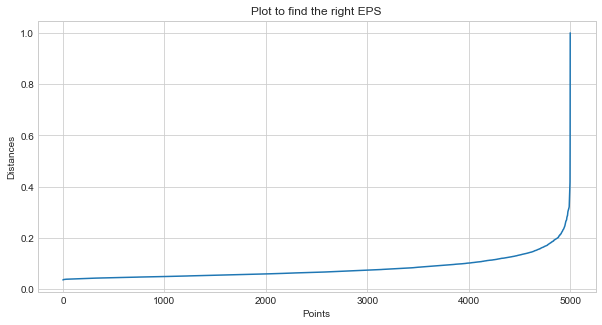

In [200]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.plot(points,sorted_distances)
plt.xlabel('Points',size=10)
plt.ylabel('Distances',size=10)
plt.title('Plot to find the right EPS')
plt.show()

##### It can be observed that there is a steep increase in the distance values after the epsilon value of 0.18 . 

In [218]:
opt_eps = 0.18
dbscan_summary(opt_eps,min_pts)

The no. of points in Cluster 0 are  4981
The no. of noisy points are  19


In [219]:
dbscan_summary(0.16,min_pts)

The no. of points in Cluster 0 are  4962
The no. of noisy points are  38


In [220]:
dbscan_summary(0.25,min_pts)

The no. of points in Cluster 0 are  4998
The no. of noisy points are  2


In [221]:
dbscan_summary(0.10,min_pts)

The no. of points in Cluster 0 are  4645
The no. of noisy points are  355


### DBSCAN - TfIdf - W2V

In [222]:
tf_idf_vect = TfidfVectorizer()
x_bow = tf_idf_vect.fit_transform(cl_data['Cleaned_Text'].values)

In [223]:
dict_svm = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [224]:
from tqdm import tqdm

In [225]:
tfidf_feat= tf_idf_vect.get_feature_names()
tfidf_sent_vectors = []
row=0;
for sent in tqdm(list_of_train_sent): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if ((word in w2v_words) and (word in tfidf_feat)):
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            #tf_idf = x_train[row, tfidf_feat.index(word)]
            tf_idf = dict_svm[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:27<00:00, 179.77it/s]


In [226]:
tfidf_sent_vectors_arr = np.asarray(tfidf_sent_vectors)
x_bow = normalize(tfidf_sent_vectors_arr)

In [227]:
min_pts = 2 * x_bow.shape[1]
points = [i for i in range(x_bow.shape[0])]

In [228]:
sorted_distances = nth_nearest_neighbour(x_bow,min_pts)

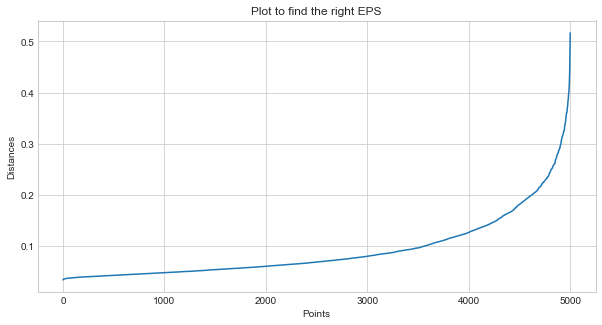

In [229]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.plot(points,sorted_distances)
plt.xlabel('Points',size=10)
plt.ylabel('Distances',size=10)
plt.title('Plot to find the right EPS')
plt.show()

##### It can be observed that there is a steep increase in the distance values after the epsilon value of 0.20 . 

In [232]:
opt_eps = 0.20
dbscan_summary(opt_eps,min_pts)

The no. of points in Cluster 0 are  4933
The no. of noisy points are  66


In [233]:
dbscan_summary(0.16,min_pts)

The no. of points in Cluster 0 are  4786
The no. of noisy points are  213


In [234]:
dbscan_summary(0.10,min_pts)

The no. of points in Cluster 0 are  4256
The no. of noisy points are  743


In [235]:
dbscan_summary(0.25,min_pts)

The no. of points in Cluster 0 are  4995
The no. of noisy points are  4
